In [1]:
import collections
import csv
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib inline
%config InlineBackend.figure_format = 'png'

# For recent conferences, I've had HotCRP complain about missing fonts unless I include this line
matplotlib.rcParams['pdf.fonttype'] = 42

In [2]:
def time_to_secs(time_string):
    secs = 0
    tokens = time_string.split(":")
    if len(tokens) == 3:
        hours = int(tokens[0])
        secs += 3600 * hours
        tokens = tokens[1:]
    if len(tokens) == 2:
        minutes = int(tokens[0])
        secs += 60 * minutes
        tokens = tokens[1:]
    assert(len(tokens) == 1)
    secs += float(tokens[0])
    return secs

def micros_empty_to_secs(micros_string):
    if micros_string == "":
        return 0.0
    return float(micros_string) / 1000000

In [3]:
MeasurementTuple = collections.namedtuple("MeasurementTuple", ("ratio",
                                                               "num_major_faults",
                                                               "num_total_faults",
                                                               "user_time",
                                                               "wall_clock_time",
                                                               "pages_evicted",
                                                               "pages_swapped_in",
                                                               "page_fault_time",
                                                               "swap_in_time",
                                                               "evict_time",
                                                               "lock_minpf_time"))

class Measurement(MeasurementTuple):
    @property
    def num_minor_faults(self):
        return self.num_total_faults - self.num_major_faults

class RatioSweep(object):
    def __init__(self, stats_filename, cgroup_filename, ftrace_filename):
        # Maps ratio (100, 90, 80, etc.) to Measurement object describing the stat
        self.by_ratio = {}
        
        # Maps ratio to list of rows
        with open(stats_filename) as sf:
            sr = csv.DictReader(sf)
            stats_by_row = {int(row["RATIO"]) : row for row in sr}
        with open(cgroup_filename) as cf:
            cr = csv.DictReader(cf)
            cgroup_by_row = {int(row["RATIO"]) : row for row in cr}
        with open(ftrace_filename) as ff:
            fr = csv.DictReader(ff)
            ftrace_by_row = {(int(row["RATIO"]), int(row["CPU"])) : row for row in fr}
                
        for ratio in stats_by_row:
            stats = stats_by_row[ratio]
            cgroup = cgroup_by_row[ratio]
            ftrace = ftrace_by_row[(ratio, 0)]
            self.by_ratio[ratio] = Measurement(ratio,
                                               int(cgroup["NUM_MAJOR_FAULTS"]),
                                               int(cgroup["NUM_FAULTS"]),
                                               time_to_secs(stats["USER"]),
                                               time_to_secs(stats["WALLCLOCK"]),
                                               int(stats["PAGES_EVICTED"]),
                                               int(stats["PAGES_SWAPPED_IN"]),
                                               micros_empty_to_secs(ftrace["PAGE_FAULT_TIME"]),
                                               micros_empty_to_secs(ftrace["SWAPIN_TIME"]),
                                               micros_empty_to_secs(ftrace["EVICT_TIME"]),
                                               micros_empty_to_secs(ftrace["LOCK_MINPF_TIME"]) if "LOCK_MINPF_TIME" in ftrace else None)

        
class MultiTrialRatioSweep(object):
    def __init__(self, sweeps, aggregator = None):
        self.num_trials = len(sweeps)
        assert(self.num_trials != 0)
        
        self.by_ratio = {}
        
        ratios = sweeps[0].by_ratio.keys()
        for s in sweeps:
            ratios = ratios & s.by_ratio.keys()

        if aggregator is None:
            aggregator = np.median
        
        for ratio in ratios:
            measures = tuple(s.by_ratio[ratio] for s in sweeps)
            self.by_ratio[ratio] = Measurement(ratio,
                                               aggregator([m.num_major_faults for m in measures]),
                                               aggregator([m.num_total_faults for m in measures]),
                                               aggregator([m.wall_clock_time for m in measures]),
                                               aggregator([m.pages_evicted for m in measures]),
                                               aggregator([m.pages_swapped_in for m in measures]))
            

In [4]:
def parse_ratio_sweep(system, experiment_name, setup, base_directory = ".", trial = None):
    if system == "tape":
        first_directory = "tape_bench_output"
        if trial is not None:
            first_directory = "{0}_t{1}".format(first_directory, trial)
        if setup == "linux":
            third_directory = "linux_prefetching_asyncwrites"
        elif setup == "linux_sync":
            third_directory = "linux_prefetching"
        elif setup == "tape":
            third_directory = "tape_prefetching_asyncwrites"
        else:
            raise RuntimeError("Can't handle {0}".format((system, experiment_name, setup)))
        stats_filename = os.path.join(base_directory, first_directory, experiment_name, third_directory, "time_and_swap_results.csv")
        cgroup_filename = os.path.join(base_directory, first_directory, experiment_name, third_directory, "cgroup_results.csv")
        ftrace_filename = os.path.join(base_directory, first_directory, experiment_name, third_directory, "ftrace_results.csv")
        return RatioSweep(stats_filename, cgroup_filename, ftrace_filename)
    elif system == "leap":
        first_directory = "leap_bench_output"
        if trial is not None:
            first_directory = "{0}_t{1}".format(first_directory, trial)
        if setup == "linux" or setup == "linux_sync":
            stats_filename = os.path.join(base_directory, first_directory, experiment_name, "linux.stats")
            cgroup_filename = os.path.join(base_directory, first_directory, experiment_name, "leap.cgroup")
        elif setup == "leap":
            stats_filename = os.path.join(base_directory, first_directory, experiment_name, "leap.stats")
            cgroup_filename = os.path.join(base_directory, first_directory, experiment_name, "leap.cgroup")
        else:
            raise RuntimeError("Can't handle {0}".format((system, experiment_name, setup)))
        return RatioSweep(stats_filename, cgroup_filename)
    else:
        raise RuntimeError("Can't handle system {0}".format(system))

In [5]:
RATIOS = (5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100)

In [6]:
tape = parse_ratio_sweep("tape", "mmult_eigen_dot", "tape", "data")
linux = parse_ratio_sweep("tape", "mmult_eigen_dot", "linux", "data")

In [7]:
def smart_round(number):
    if number >= 100:
        return str(int(round(number, 3 - len(str(int(number))))))
    elif number >= 10:
        return "{0:.1f}".format(round(number, 1))
    elif number >= 1:
        return "{0:.2f}".format(round(number, 2))
    elif number >= 0.1:
        return "{0:.3f}".format(round(number, 3))
    elif number >= 0.01:
        return "{0:.4f}".format(round(number, 4))
    elif number >= 0.001:
        return "{0:.5f}".format(round(number, 5))
    else:
        return "negl"

In [8]:
def print_breakdown(sweep):
    print("ratio", "total", "user", "min_pf", "maj_pf", "evict", "other", sep = "\t")
    for ratio in RATIOS:
        m = sweep.by_ratio[ratio]
        print(ratio,
              m.wall_clock_time,
              smart_round(m.user_time / m.wall_clock_time),
              smart_round((m.page_fault_time - m.swap_in_time) / m.wall_clock_time),
              smart_round(m.swap_in_time / m.wall_clock_time),
              smart_round(m.evict_time / m.wall_clock_time),
              smart_round(1 - (m.user_time / m.wall_clock_time + m.page_fault_time / m.wall_clock_time + m.evict_time / m.wall_clock_time)),
              sep = "\t")

In [9]:
print_breakdown(linux)

ratio	total	user	min_pf	maj_pf	evict	other
5	4.76	0.534	0.215	0.196	0.00218	0.0527
10	5.0	0.528	0.202	0.235	0.00782	0.0271
20	4.97	0.493	0.201	0.229	0.0155	0.0610
30	7.15	0.329	0.0863	0.509	0.0263	0.0500
40	7.31	0.320	0.0822	0.520	0.0274	0.0500
50	5.62	0.418	0.170	0.200	0.151	0.0613
60	5.3	0.436	0.174	0.205	0.111	0.0732
70	4.15	0.564	0.233	0.113	0.0280	0.0612
80	4.14	0.580	0.231	0.113	0.0356	0.0408
90	4.14	0.563	0.231	0.110	0.0449	0.0516
100	3.08	0.695	0.184	0.00543	negl	0.116


In [10]:
print_breakdown(tape)

ratio	total	user	min_pf	maj_pf	evict	other
5	4.76	0.540	0.414	negl	negl	0.0464
10	4.81	0.543	0.409	negl	0.0128	0.0358
20	4.87	0.544	0.404	negl	0.0277	0.0247
30	5.0	0.510	0.391	negl	0.0572	0.0414
40	4.97	0.517	0.394	negl	0.0491	0.0394
50	5.41	0.449	0.345	negl	0.155	0.0508
60	5.16	0.467	0.335	negl	0.138	0.0590
70	3.99	0.576	0.269	negl	0.0808	0.0738
80	3.96	0.586	0.268	negl	0.0803	0.0657
90	4.03	0.576	0.261	negl	0.108	0.0553
100	3.88	0.580	0.136	0.218	negl	0.0665


In [11]:
def plot_breakdown(linux, tape):
    plt.figure(figsize=(6, 3))

    SLICE_RATIO = 20
    linux_m = linux.by_ratio[SLICE_RATIO]
    tape_m = tape.by_ratio[SLICE_RATIO]

    x = (0, 1)

    def get_components(m):
        return (m.user_time,
                m.evict_time,
                m.swap_in_time,
                m.lock_minpf_time or 0,
                m.page_fault_time - m.swap_in_time - (m.lock_minpf_time or 0),
                m.wall_clock_time - m.user_time - m.evict_time - m.page_fault_time)

    linux_c = get_components(linux_m)
    tape_c = get_components(tape_m)
    names = ("user time", "evictions", "major pf", "minor pf (delayed hits)", "minor pf (other)", "other")

    total = np.array((0.0, 0.0))
    for items in zip(linux_c, tape_c, names):
        label = items[2]
        arr = np.array(items[:2])
        plt.bar(x, arr, label = label, bottom = total)
        total += arr
        
    plt.ylabel("Runtime (s)")
    plt.xticks(x, ("linux", "tape"))
    
    plt.xlim(-0.5, 3.5)

    plt.legend()
    plt.show()
    
def plot_breakdown_exp(system, exp, base_directory):
    tape_minpf = parse_ratio_sweep(system, exp, "tape", base_directory)
    linux_minpf = parse_ratio_sweep(system, exp, "linux", base_directory)
    plot_breakdown(linux_minpf, tape_minpf)

Comparison: After Reboot vs. After Swapping for a While (Major PF Bug)
===========================================================

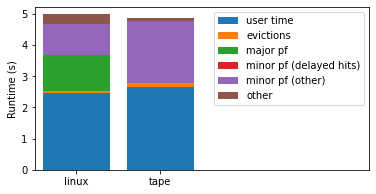

In [12]:
plot_breakdown_exp("tape", "mmult_eigen_dot", "data")

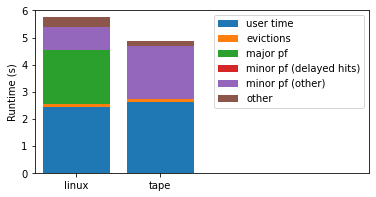

In [13]:
plot_breakdown_exp("tape", "mmult_eigen_dot", "data_5")

Breakdown Including Delayed Hits (0-Switch 10 Gbit Setup)
================================================

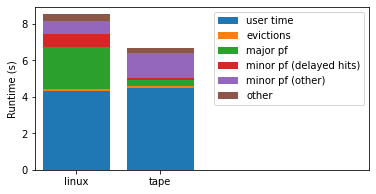

In [14]:
plot_breakdown_exp("tape", "python", "data_minpf")

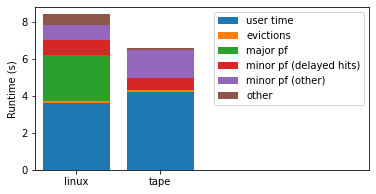

In [15]:
plot_breakdown_exp("tape", "mmult_eigen", "data_minpf")

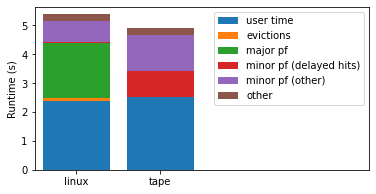

In [16]:
plot_breakdown_exp("tape", "mmult_eigen_vec", "data_minpf")

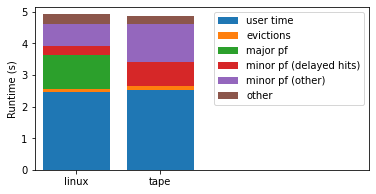

In [17]:
plot_breakdown_exp("tape", "mmult_eigen_dot", "data_minpf")

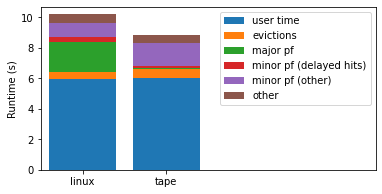

In [18]:
plot_breakdown_exp("tape", "sparse_eigen", "data_minpf")